# Projet Bayes 2 - Hearts

## Importation des données

In [54]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [7]:
path = "data.csv"

In [10]:
data = pd.read_csv(path)
data

,Unnamed: 0,t,x,y
0,1,11,6,5
1,2,11,9,2
2,3,17,17,0
3,4,22,22,0
4,5,9,7,2
5,6,6,5,1
6,7,5,5,0
7,8,14,14,0
8,9,9,9,0
9,10,7,7,0


## Échantilloneur

In [12]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [20]:
init = [0,0]

In [276]:
def MH (data,init,n,prop_sd,sigma = 1e2) :
    # X = [alpha, beta, delta, theta]
    X = np.zeros((n+1,4), dtype=np.float32)
    X[0] = [init[0],
            np.exp(init[0]),
            init[1],
            sigmoid(init[1])]
    id0 = (data["y"] == 0)
    id_sup = ~id0
    
    # Calcul des probas d'acceptation
    P = [0,0]
    
    for i in range(1,n+1) :
        # Calcul de alpha
        alpha = X[i-1,0]
        theta = X[i-1,3]
        prop_alpha = np.random.normal(alpha,prop_sd[0])
        
        def log_pdf_alpha(x) :
            p = sigmoid(x)
            
            s = -(x**2)/(2*sigma**2) + \
            np.sum(np.log(theta + (1-theta)*(1-p)**data[id0]["t"])) + \
            np.sum(data[id_sup]["y"]*np.log(p) + (data[id_sup]["t"] - data[id_sup]["y"])*np.log(1-p))
            
            return s
        
        top = log_pdf_alpha(prop_alpha)
        bottom = log_pdf_alpha(alpha)
        acc = np.exp(top - bottom)
        
        if np.random.uniform() < acc :
            X[i,0] = prop_alpha
            P[0] +=1
        else : 
            X[i,0] = alpha
        
        # Calcul de delta
        delta = X[i-1,2]
        p = sigmoid(X[i,0])
        prop_delta = np.random.normal(delta,prop_sd[1])
        
        def log_pdf_delta(x) :
            theta = sigmoid(x)
            
            s = -(x**2)/(2*sigma**2) + \
            np.sum(np.log(theta + (1-theta)*(1-p)**data[id0]["t"])) + \
            np.log(1-theta)*np.sum(id_sup)
            
            return s
        
        top = log_pdf_delta(prop_delta)
        bottom = log_pdf_delta(delta)

        acc = np.exp(top - bottom)
        
        if np.random.uniform() < acc :
            X[i,2] = prop_delta
            P[1] += 1
        else : 
            X[i,2] = delta
            
        # Calcul de beta et theta
        X[i,1] = np.exp(X[i,0])
        X[i,3] = sigmoid(X[i,2])
        
    return (X,np.array(P)/n)

In [277]:
X,P = MH(data,init,10000,[0.05,1])

## Analyse des résultats

In [278]:
X_burn = X[1000:]
alpha = X_burn[:,0]
beta = X_burn[:,1]
delta = X_burn[:,2]
theta = X_burn[:,3]

Text(0.5, 1.0, 'Theta')

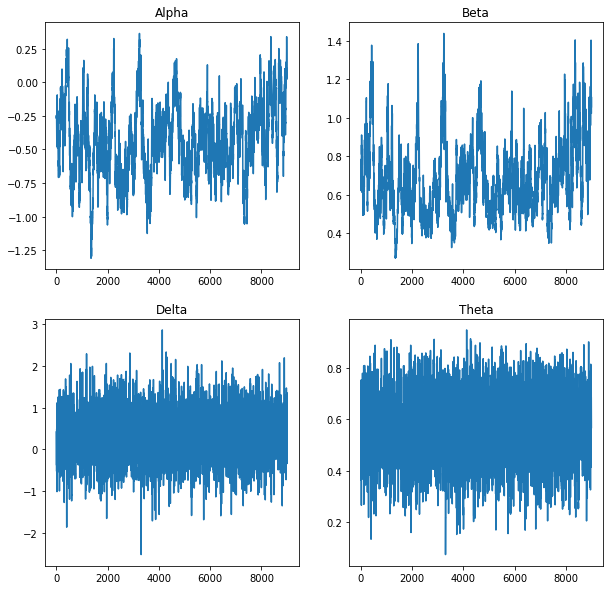

In [279]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))

# alpha
ax[0,0].plot(alpha)
ax[0,0].set_title("Alpha")

# beta
ax[0,1].plot(beta)
ax[0,1].set_title("Beta")

# delta
ax[1,0].plot(delta)
ax[1,0].set_title("Delta")

# theta
ax[1,1].plot(theta)
ax[1,1].set_title("Theta")

In [280]:
P

array([0.9413, 0.571 ])

In [282]:
coef = {'alpha': alpha,
       'beta': beta,
       'delta': delta,
       'theta': theta}
coef = pd.DataFrame(coef)
coef.describe(percentiles=[0.025,0.975])

,alpha,beta,delta,theta
count,9001.000000,9001.000000,9001.000000,9001.000000
mean,-0.422886,0.680051,0.302510,0.569320
std,0.272203,0.189878,0.607239,0.137428
min,-1.308135,0.270324,-2.526941,0.073991
2.5%,-0.914620,0.400669,-0.882637,0.292632
50%,-0.425881,0.653194,0.292690,0.572655
97.5%,0.124556,1.132645,1.479753,0.814535
max,0.362895,1.437485,2.860179,0.945842
